In [ ]:
import pandas as pd

In [ ]:
df_skipped = pd.read_csv('/home/ali/hnswlib/results/fullopenaidecompose_hnsw_per_query_skipping.csv')
df_original = pd.read_csv('/home/ali/hnswlib/results/fullopenaidecompose_hnsw_per_query.csv')

In [ ]:
df_skipped

In [ ]:
# Check if skipping dataset results are superset of original dataset
def check_superset_relationship(df_skipped, df_original):
    """
    Check if the retrieved results in df_skipped are a superset of df_original.
    
    Parameters:
    df_skipped: DataFrame with skipping results
    df_original: DataFrame with original results
    
    Returns:
    dict: Analysis results including superset status and statistics
    """
    
    # Ensure both dataframes have the same number of rows and are aligned
    if len(df_skipped) != len(df_original):
        print(f"Warning: Different number of rows - Skipped: {len(df_skipped)}, Original: {len(df_original)}")
        min_len = min(len(df_skipped), len(df_original))
        df_skipped = df_skipped.iloc[:min_len]
        df_original = df_original.iloc[:min_len]
    
    def parse_k_column(k_series):
        """Parse semicolon-separated results from k column into sets of individual IDs"""
        all_results = set()
        for k_str in k_series:
            if pd.notna(k_str) and str(k_str).strip():
                # Split by semicolon and add individual IDs
                ids = [id_str.strip() for id_str in str(k_str).split(';') if id_str.strip()]
                all_results.update(ids)
        return all_results
    
    # Group by query and parse the k column results
    skipped_groups = {}
    original_groups = {}
    
    for (query_parent_id, query_vector_local_idx), group in df_skipped.groupby(['query_parent_id', 'query_vector_local_idx']):
        # Parse the 'k' column which contains semicolon-separated results
        skipped_groups[(query_parent_id, query_vector_local_idx)] = parse_k_column(group['k'])
    
    for (query_parent_id, query_vector_local_idx), group in df_original.groupby(['query_parent_id', 'query_vector_local_idx']):
        # Parse the 'k' column which contains semicolon-separated results
        original_groups[(query_parent_id, query_vector_local_idx)] = parse_k_column(group['k'])
    
    # Check superset relationship for each query
    superset_results = []
    total_queries = len(skipped_groups)
    
    for query_key in skipped_groups:
        if query_key in original_groups:
            skipped_results = skipped_groups[query_key]
            original_results = original_groups[query_key]
            
            # Check if skipped results contain all original results
            is_superset = original_results.issubset(skipped_results)
            
            # Calculate additional metrics
            common_results = skipped_results.intersection(original_results)
            only_in_skipped = skipped_results - original_results
            only_in_original = original_results - skipped_results
            
            superset_results.append({
                'query_key': query_key,
                'is_superset': is_superset,
                'skipped_count': len(skipped_results),
                'original_count': len(original_results),
                'common_count': len(common_results),
                'only_in_skipped': len(only_in_skipped),
                'only_in_original': len(only_in_original),
                'skipped_results': skipped_results,
                'original_results': original_results
            })
        else:
            print(f"Warning: Query {query_key} not found in original dataset")
    
    # Calculate overall statistics
    total_superset = sum(1 for result in superset_results if result['is_superset'])
    total_queries_checked = len(superset_results)
    
    # Calculate average differences
    avg_skipped_count = sum(result['skipped_count'] for result in superset_results) / total_queries_checked
    avg_original_count = sum(result['original_count'] for result in superset_results) / total_queries_checked
    avg_common_count = sum(result['common_count'] for result in superset_results) / total_queries_checked
    avg_only_in_skipped = sum(result['only_in_skipped'] for result in superset_results) / total_queries_checked
    avg_only_in_original = sum(result['only_in_original'] for result in superset_results) / total_queries_checked
    
    return {
        'total_queries': total_queries_checked,
        'superset_queries': total_superset,
        'non_superset_queries': total_queries_checked - total_superset,
        'superset_percentage': (total_superset / total_queries_checked) * 100,
        'avg_skipped_count': avg_skipped_count,
        'avg_original_count': avg_original_count,
        'avg_common_count': avg_common_count,
        'avg_only_in_skipped': avg_only_in_skipped,
        'avg_only_in_original': avg_only_in_original,
        'detailed_results': superset_results
    }

# Run the analysis
print("Analyzing superset relationship between skipping and original datasets...")
results = check_superset_relationship(df_skipped, df_original)

print(f"\n=== SUPERSET ANALYSIS RESULTS ===")
print(f"Total queries analyzed: {results['total_queries']}")
print(f"Queries where skipping is superset: {results['superset_queries']}")
print(f"Queries where skipping is NOT superset: {results['non_superset_queries']}")
print(f"Superset percentage: {results['superset_percentage']:.2f}%")
print(f"\n=== AVERAGE STATISTICS ===")
print(f"Average results in skipping dataset: {results['avg_skipped_count']:.2f}")
print(f"Average results in original dataset: {results['avg_original_count']:.2f}")
print(f"Average common results: {results['avg_common_count']:.2f}")
print(f"Average results only in skipping: {results['avg_only_in_skipped']:.2f}")
print(f"Average results only in original: {results['avg_only_in_original']:.2f}")


In [ ]:
# Show examples of non-superset cases
print("\n=== EXAMPLES OF NON-SUPERSET CASES ===")
non_superset_cases = [result for result in results['detailed_results'] if not result['is_superset']]

if non_superset_cases:
    print(f"Found {len(non_superset_cases)} non-superset cases. Showing first 3 examples:")
    for i, case in enumerate(non_superset_cases[:3]):
        print(f"\nExample {i+1}:")
        print(f"  Query: {case['query_key']}")
        print(f"  Original count: {case['original_count']}, Skipped count: {case['skipped_count']}")
        print(f"  Common count: {case['common_count']}, Only in original: {case['only_in_original']}, Only in skipped: {case['only_in_skipped']}")
        
        # Show first 10 IDs from each set for readability
        original_list = sorted(list(case['original_results']))
        skipped_list = sorted(list(case['skipped_results']))
        only_original = sorted(list(case['original_results'] - case['skipped_results']))
        only_skipped = sorted(list(case['skipped_results'] - case['original_results']))
        
        print(f"  Original results (first 10): {original_list[:10]}{'...' if len(original_list) > 10 else ''}")
        print(f"  Skipped results (first 10): {skipped_list[:10]}{'...' if len(skipped_list) > 10 else ''}")
        print(f"  Only in original (first 10): {only_original[:10]}{'...' if len(only_original) > 10 else ''}")
        print(f"  Only in skipped (first 10): {only_skipped[:10]}{'...' if len(only_skipped) > 10 else ''}")
else:
    print("All queries are supersets! The skipping dataset contains all results from the original dataset.")

# Show examples of superset cases
print("\n=== EXAMPLES OF SUPERSET CASES ===")
superset_cases = [result for result in results['detailed_results'] if result['is_superset']]

if superset_cases:
    print(f"Found {len(superset_cases)} superset cases. Showing first 3 examples:")
    for i, case in enumerate(superset_cases[:3]):
        print(f"\nExample {i+1}:")
        print(f"  Query: {case['query_key']}")
        print(f"  Original count: {case['original_count']}, Skipped count: {case['skipped_count']}")
        print(f"  Common count: {case['common_count']}, Additional in skipped: {case['only_in_skipped']}")
        
        # Show first 10 IDs from each set for readability
        original_list = sorted(list(case['original_results']))
        skipped_list = sorted(list(case['skipped_results']))
        additional_skipped = sorted(list(case['skipped_results'] - case['original_results']))
        common = sorted(list(case['original_results'].intersection(case['skipped_results'])))
        
        print(f"  Original results (first 10): {original_list[:10]}{'...' if len(original_list) > 10 else ''}")
        print(f"  Skipped results (first 10): {skipped_list[:10]}{'...' if len(skipped_list) > 10 else ''}")
        print(f"  Additional in skipped (first 10): {additional_skipped[:10]}{'...' if len(additional_skipped) > 10 else ''}")
        print(f"  Common results (first 10): {common[:10]}{'...' if len(common) > 10 else ''}")


In [ ]:
non_superset_cases[0]['original_results']

In [ ]:
string = "68982;837138;267103;18547;366842;462893;444811;325087;933083;655557;909876;621309;849956;883141;277827;963215;708327;578710;445070;989627;123801;182004;294150;393282;326956;604776;285883;912764;894594;603173;209346;985592;263352;587431;78330;908951;934366;562575;844022;963017;636127;290231;422860;797848;705056;551729;40510;802874;195821;343293;834633;641106;591159;267693;345480;394981;788280;431071;170597;447071;445070;315791;958817;491322;332838;907084;432737;860476;708327;783621;604776;17964;414775;753966;899236;877266;683224;81645;551420;562661;313297;282232;512034;488101;356561;559042;394399;488101;48495;636311;216190;551642;264903;418068;551642;206796;983837;241439;890260;40510"
original_res100 = string.split(';')
original_res100.sort()
string = "688192;375758;975510;2615;201289;966847;790634;68982;837138;267103;18547;366842;462893;444811;325087;933083;655557;909876;621309;849956;883141;277827;963215;578710;123801;182004;294150;393282;326956;285883;912764;894594;603173;209346;985592;263352;587431;78330;908951;562575;844022;963017;636127;290231;422860;797848;705056;551729;802874;195821;343293;834633;641106;591159;267693;345480;394981;788280;431071;170597;119342;447071;445070;315791;958817;491322;332838;907084;432737;860476;708327;783621;604776;17964;414775;753966;899236;877266;683224;81645;551420;562661;313297;282232;512034;356561;559042;394399;488101;48495;636311;216190;264903;418068;551642;206796;983837;241439;890260;40510"
skipped_res100 = string.split(";")
skipped_res100.sort()

In [ ]:
string = "551729;802874;195821;343293;834633;641106;591159;267693;345480;394981;788280;431071;476150;170597;119342;447071;445070;315791;958817;491322;332838;907084;860476;17964;414775;753966;899236;877266;683224;81645;551420;562661;313297;282232;512034;356561;559042;394399;488101;48495;636311;216190;264903;418068;551642;206796;983837;241439;890260;40510"
skipped_res50 = string.split(";")
skipped_res50.sort()
string = "195821;343293;834633;641106;591159;267693;345480;394981;788280;431071;476150;170597;119342;447071;445070;315791;958817;491322;332838;907084;860476;17964;414775;753966;899236;877266;683224;81645;551420;562661;313297;282232;512034;488101;356561;559042;394399;488101;48495;636311;216190;551642;264903;418068;551642;206796;983837;241439;890260;40510"
original_res50 = string.split(';')
original_res50.sort()

In [ ]:

# Convert to sets and find intersection
skipped_set = set(skipped_res100)
original_set = set(original_res100)

# Find common elements
common = skipped_set.intersection(original_set)
print(f"Common elements: {common}")  # {3, 4, 5}

# Find elements only in skipped
only_in_skipped = skipped_set - original_set
print(f"Only in skipped: {only_in_skipped}")  # {1, 2}

# Find elements only in original
only_in_original = original_set - skipped_set
print(f"Only in original: {only_in_original}")  # {6, 7}

# Check if skipped is superset of original
is_superset = original_set.issubset(skipped_set)
print(f"Is superset: {is_superset}")  # False

# Check if they are equal
are_equal = skipped_set == original_set
print(f"Are equal: {are_equal}")  # False

In [ ]:
# Convert to sets and find intersection
skipped_set = set(skipped_res50)
original_set = set(original_res50)

# Find common elements
common = skipped_set.intersection(original_set)
print(f"Common elements: {common}")  # {3, 4, 5}

# Find elements only in skipped
only_in_skipped = skipped_set - original_set
print(f"Only in skipped: {only_in_skipped}")  # {1, 2}

# Find elements only in original
only_in_original = original_set - skipped_set
print(f"Only in original: {only_in_original}")  # {6, 7}

# Check if skipped is superset of original
is_superset = original_set.issubset(skipped_set)
print(f"Is superset: {is_superset}")  # False

# Check if they are equal
are_equal = skipped_set == original_set
print(f"Are equal: {are_equal}")  # False

In [ ]:
# Convert to sets and find intersection
skipped_set = set(skipped_res100)
original_set = set(original_res50)

# Find common elements
common = skipped_set.intersection(original_set)
print(f"Common elements: {common}")  # {3, 4, 5}

# Find elements only in skipped
only_in_skipped = skipped_set - original_set
print(f"Only in skipped: {only_in_skipped}")  # {1, 2}

# Find elements only in original
only_in_original = original_set - skipped_set
print(f"Only in original: {only_in_original}")  # {6, 7}

# Check if skipped is superset of original
is_superset = original_set.issubset(skipped_set)
print(f"Is superset: {is_superset}")  # False

# Check if they are equal
are_equal = skipped_set == original_set
print(f"Are equal: {are_equal}")  # False

In [ ]:
len(only_in_skipped)

In [ ]:
original_set = set(original_res100)


In [ ]:
is_superset = only_in_skipped.issubset(original_set)
print(f"Is superset: {is_superset}")  # False

In [ ]:
only_in_original = original_set - only_in_skipped

In [ ]:
len(only_in_original)

In [ ]:
def has_duplicates(lst):
    return len(lst) != len(set(lst))

print(has_duplicates(original_res100))  # False

In [ ]:
len(set(original_res50))

In [ ]:
# First, let's examine the structure of df_skipped
print("DataFrame shape:", df_skipped.shape)
print("\nColumn names:")
print(df_skipped.columns.tolist())
print("\nFirst few rows:")
print(df_skipped.head())
print("\nData types:")
print(df_skipped.dtypes)


In [ ]:
# Let's look at the unique values in query_parent_id and understand the data better
print("Unique query_parent_id values (first 20):")
print(df_skipped['query_parent_id'].unique()[:20])
print(f"\nTotal unique query_parent_id values: {df_skipped['query_parent_id'].nunique()}")
print(f"Total rows: {len(df_skipped)}")

print("\nSample of query_vector_local_idx values:")
print(df_skipped['query_vector_local_idx'].unique()[:20])
print(f"\nTotal unique query_vector_local_idx values: {df_skipped['query_vector_local_idx'].nunique()}")

print("\nSample of 'k' column (first 3 entries):")
for i in range(3):
    print(f"Row {i}: {df_skipped['k'].iloc[i]}")


In [ ]:
def analyze_shared_ids_by_parent(df):
    """
    Analyze how many IDs in the retrieved results 'k' are shared among all vectors from the same parent.
    
    Parameters:
    df: DataFrame with columns 'query_parent_id', 'query_vector_local_idx', and 'k'
    
    Returns:
    dict: Analysis results including shared IDs statistics
    """
    
    def parse_k_column(k_str):
        """Parse semicolon-separated results from k column into set of individual IDs"""
        if pd.notna(k_str) and str(k_str).strip():
            # Split by semicolon and add individual IDs
            ids = [id_str.strip() for id_str in str(k_str).split(';') if id_str.strip()]
            return set(ids)
        return set()
    
    # Group by query_parent_id
    parent_groups = df.groupby('query_parent_id')
    
    analysis_results = []
    
    for parent_id, group in parent_groups:
        # Get all vectors for this parent
        vectors = group['query_vector_local_idx'].tolist()
        vector_count = len(vectors)
        
        # Parse the 'k' column for each vector
        vector_results = {}
        for idx, row in group.iterrows():
            vector_idx = row['query_vector_local_idx']
            k_results = parse_k_column(row['k'])
            vector_results[vector_idx] = k_results
        
        # Find shared IDs across all vectors from this parent
        if vector_count > 1:
            # Start with the first vector's results
            shared_ids = vector_results[vectors[0]].copy()
            
            # Intersect with all other vectors
            for vector_idx in vectors[1:]:
                shared_ids = shared_ids.intersection(vector_results[vector_idx])
        else:
            # Only one vector, so all its IDs are "shared" (trivially)
            shared_ids = vector_results[vectors[0]].copy()
        
        # Calculate statistics for this parent
        total_unique_ids = set()
        for vector_idx in vectors:
            total_unique_ids.update(vector_results[vector_idx])
        
        # Calculate per-vector statistics
        vector_stats = []
        for vector_idx in vectors:
            vector_set = vector_results[vector_idx]
            shared_in_this_vector = len(shared_ids.intersection(vector_set))
            vector_stats.append({
                'vector_idx': vector_idx,
                'total_retrieved': len(vector_set),
                'shared_ids_count': shared_in_this_vector,
                'shared_percentage': (shared_in_this_vector / len(vector_set)) * 100 if len(vector_set) > 0 else 0
            })
        
        analysis_results.append({
            'parent_id': parent_id,
            'vector_count': vector_count,
            'shared_ids': shared_ids,
            'shared_ids_count': len(shared_ids),
            'total_unique_ids': total_unique_ids,
            'total_unique_count': len(total_unique_ids),
            'shared_percentage': (len(shared_ids) / len(total_unique_ids)) * 100 if len(total_unique_ids) > 0 else 0,
            'vector_stats': vector_stats
        })
    
    return analysis_results

# Run the analysis
print("Analyzing shared IDs among vectors from the same parent...")
shared_analysis = analyze_shared_ids_by_parent(df_skipped)

print(f"\n=== SHARED IDS ANALYSIS RESULTS ===")
print(f"Total parents analyzed: {len(shared_analysis)}")

# Calculate overall statistics
total_shared_ids = sum(result['shared_ids_count'] for result in shared_analysis)
total_unique_ids = sum(result['total_unique_count'] for result in shared_analysis)
parents_with_shared = sum(1 for result in shared_analysis if result['shared_ids_count'] > 0)
parents_with_multiple_vectors = sum(1 for result in shared_analysis if result['vector_count'] > 1)

print(f"Parents with multiple vectors: {parents_with_multiple_vectors}")
print(f"Parents with shared IDs: {parents_with_shared}")
print(f"Average shared IDs per parent: {total_shared_ids / len(shared_analysis):.2f}")
print(f"Average unique IDs per parent: {total_unique_ids / len(shared_analysis):.2f}")
print(f"Overall shared percentage: {(total_shared_ids / total_unique_ids) * 100:.2f}%")


In [ ]:
df_skipped.head()

In [ ]:
parent_groups = df_skipped.groupby(['query_parent_id'])
k = [1, 5, 10, 20, 50, 100]
duplicates_topk = {}
for topk in k:
    duplicates_topk_this = []
    for parent_id, group in parent_groups:
        retrived_topk = []
        counter = 0
        for idx, row in group[group['query_vector_global_idx'] == topk].iterrows():
            for id_str in row['k'].split(';'):
                retrived_topk.append(id_str)
            counter += 1
        duplicates_topk_this.append(((len(retrived_topk) - len(set(retrived_topk))), counter))
    duplicates_topk[topk] = duplicates_topk_this

In [ ]:
def duplication_percentages(data):
    # data: dict[int, list[tuple[int, int]]] -> {k: [(dup_count, vector_count), ...]}
    result = {}
    for k, pairs in data.items():
        total_dups = sum(d for d, n in pairs)
        total_vecs = sum(n for d, n in pairs)
        print("K: ", k)
        print("Total number of retrived results: ", total_vecs*k)
        print("Total number of duplicates: ", total_dups)
        result[k] = 0.0 if total_vecs == 0 else (total_dups / (total_vecs*k)) * 100.0
    return result

In [ ]:
duplication_percentages(duplicates_topk)

In [ ]:
import matplotlib.pyplot as plt

def summarize_duplications(data):
    rows = []
    for k, pairs in data.items():
        total_dups = sum(d for d, n in pairs)
        total_vecs = sum(n for d, n in pairs)
        total_retrieved = total_vecs * k
        dup_pct = 0.0 if total_retrieved == 0 else (total_dups / total_retrieved) * 100.0
        rows.append({
            "k": k,
            "total_vecs": total_vecs,
            "total_retrieved": total_retrieved,
            "total_dups": total_dups,
            "dup_pct": dup_pct,
        })
    return pd.DataFrame(rows).sort_values("k")

df = summarize_duplications(duplicates_topk)
display(df)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df["k"], df["dup_pct"], marker="o")
plt.xlabel("k")
plt.ylabel("Duplication %")
plt.title("Duplication Percentage per k")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

per_tuple_pct = {
    k: [0.0 if n == 0 else (d/n)*100.0 for d, n in pairs]
    for k, pairs in duplicates_topk.items()
}
stats = [
    (k, np.mean(v), np.std(v)) for k, v in per_tuple_pct.items() if len(v) > 0
]
ks, means, stds = zip(*sorted(stats))

plt.figure(figsize=(6,4))
plt.errorbar(ks, means, yerr=stds, fmt="-o", capsize=3)
plt.xlabel("k")
plt.ylabel("Duplication % (mean ± std)")
plt.title("Per-tuple duplication % per k")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# assumes df has columns: k, total_retrieved, total_dups, unique_retrieved, dup_pct
df_plot = df.sort_values("k").copy()
ks = df_plot["k"].to_numpy()
unique_vals = df_plot["unique_retrieved"].to_numpy()
dup_vals = df_plot["total_dups"].to_numpy()
dup_pct_vals = df_plot["dup_pct"].to_numpy()

total_unique = int(unique_vals.sum())
total_dups = int(dup_vals.sum())
overall_pct = 0.0 if (total_unique + total_dups) == 0 else (total_dups / (total_unique + total_dups)) * 100

fig, ax = plt.subplots(figsize=(14, 9))

# stacked bars
bar_width = 0.6
x = np.arange(len(ks))
bars_unique = ax.bar(x, unique_vals, width=bar_width, color="#6baed6", label="Unique retrieved")
bars_dups = ax.bar(x, dup_vals, width=bar_width, bottom=unique_vals, color="#fb6a4a", label="Duplicates")

# secondary axis for duplication %
ax2 = ax.twinx()
ax2.plot(x, dup_pct_vals, color="#2c7fb8", marker="o", linewidth=2, label="Duplication %")
ax2.set_ylabel("Duplication %")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# x formatting
ax.set_xticks(x)
ax.set_xticklabels(ks)
ax.set_xlabel("k")

# y formatting (counts)
ax.set_ylabel("Count")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, pos: f"{int(v):,}"))

# grid and limits
ax.grid(axis="y", alpha=0.25)
ax.set_axisbelow(True)

# annotations: counts inside bars
def annotate_bars(bar_container, values, y_offset=3):
    for rect, val in zip(bar_container, values):
        if val <= 0:
            continue
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            rect.get_y() + rect.get_height() / 2.0,
            f"{int(val):,}",
            va="center", ha="center", color="white", fontsize=9, fontweight="bold"
        )

annotate_bars(bars_dups, dup_vals)  # label inside the red duplicate segments
annotate_bars(bars_unique, unique_vals)

# annotations: duplication % above each stacked bar
for xi, uniq, dup, pct in zip(x, unique_vals, dup_vals, dup_pct_vals):
    total = uniq + dup
    if total <= 0:
        continue
    ax.text(
        xi,
        total + max(total * 0.015, 5),
        f"{pct:.1f}%",
        ha="center", va="bottom", fontsize=9, color="#2c7fb8", fontweight="bold"
    )

# legend: combine from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc="upper left", frameon=False)

# title + subtitle
ax.set_title("Retrieved results per k: unique vs duplicates", pad=12, fontsize=13, fontweight="bold")
ax.text(
    0.0, 1.02,
    f"Totals — Unique: {total_unique:,} | Duplicates: {total_dups:,} ({overall_pct:.1f}%)",
    transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color="#555"
)

plt.tight_layout()
plt.show()

In [ ]:
# Show detailed examples of parents with shared IDs
print("\n=== EXAMPLES OF PARENTS WITH SHARED IDS ===")

# Filter parents with multiple vectors and shared IDs
parents_with_shared_examples = [result for result in shared_analysis 
                               if result['vector_count'] > 1 and result['shared_ids_count'] > 0]

print(f"Found {len(parents_with_shared_examples)} parents with multiple vectors and shared IDs.")
print("Showing first 5 examples:")

for i, parent_result in enumerate(parents_with_shared_examples[:5]):
    print(f"\nExample {i+1}: Parent ID {parent_result['parent_id']}")
    print(f"  Number of vectors: {parent_result['vector_count']}")
    print(f"  Shared IDs count: {parent_result['shared_ids_count']}")
    print(f"  Total unique IDs: {parent_result['total_unique_count']}")
    print(f"  Shared percentage: {parent_result['shared_percentage']:.2f}%")
    
    # Show the actual shared IDs (first 10)
    shared_ids_list = sorted(list(parent_result['shared_ids']))
    print(f"  Shared IDs (first 10): {shared_ids_list[:10]}{'...' if len(shared_ids_list) > 10 else ''}")
    
    # Show per-vector statistics
    print(f"  Per-vector statistics:")
    for vector_stat in parent_result['vector_stats']:
        print(f"    Vector {vector_stat['vector_idx']}: {vector_stat['total_retrieved']} retrieved, "
              f"{vector_stat['shared_ids_count']} shared ({vector_stat['shared_percentage']:.1f}%)")


In [ ]:
import numpy as np
import struct

def read_binary_similarities(file_path):
    """
    Read binary similarity results file produced by the C++ test code.
    
    The binary format is:
    - Header: 2 x uint32_t (NQ, N)
    - Data: NQ x N x float32 (similarities for each query)
    
    Args:
        file_path (str): Path to the binary file
        
    Returns:
        tuple: (NQ, N, similarities_matrix) where:
            - NQ: number of queries
            - N: number of data vectors  
            - similarities_matrix: numpy array of shape (NQ, N) containing similarities
    """
    with open(file_path, 'rb') as f:
        # Read header: NQ and N as uint32_t
        nq_bytes = f.read(4)
        n_bytes = f.read(4)
        
        if len(nq_bytes) != 4 or len(n_bytes) != 4:
            raise ValueError("File too short to contain header")
            
        NQ = struct.unpack('<I', nq_bytes)[0]  # little-endian uint32
        N = struct.unpack('<I', n_bytes)[0]    # little-endian uint32
        
        print(f"Reading binary file: {NQ} queries, {N} data vectors")
        
        # Read all similarity data as float32
        data_bytes = f.read()
        expected_bytes = NQ * N * 4  # 4 bytes per float32
        
        if len(data_bytes) != expected_bytes:
            raise ValueError(f"File size mismatch. Expected {expected_bytes} bytes, got {len(data_bytes)}")
        
        # Convert bytes to numpy array and reshape
        similarities = np.frombuffer(data_bytes, dtype=np.float32).reshape(NQ, N)
        
        return NQ, N, similarities

In [1]:
import struct
import numpy as np
def read_binary_data(file_path, data_type='float32'):
    """
    Read binary data file with flexible data type support.
    
    The binary format is:
    - Header: 2 x uint32_t (NQ, N)
    - Data: NQ x N x data_type (data for each query)
    
    Args:
        file_path (str): Path to the binary file
        data_type (str): Data type to read ('float32', 'uint32', 'int32', 'float64', etc.)
        
    Returns:
        tuple: (NQ, N, data_matrix) where:
            - NQ: number of queries
            - N: number of data vectors  
            - data_matrix: numpy array of shape (NQ, N) containing the data
    """
    with open(file_path, 'rb') as f:
        # Read header: NQ and N as uint32_t
        nq_bytes = f.read(4)
        n_bytes = f.read(4)
        
        if len(nq_bytes) != 4 or len(n_bytes) != 4:
            raise ValueError("File too short to contain header")
            
        NQ = struct.unpack('<I', nq_bytes)[0]  # little-endian uint32
        N = struct.unpack('<I', n_bytes)[0]    # little-endian uint32
        
        print(f"Reading binary file: {NQ} queries, {N} data vectors, dtype={data_type}")
        
        # Read all data
        data_bytes = f.read()
        
        # Calculate expected bytes based on data type
        dtype_obj = np.dtype(data_type)
        bytes_per_element = dtype_obj.itemsize
        expected_bytes = NQ * N * bytes_per_element
        
        if len(data_bytes) != expected_bytes:
            print(f"Warning: File size mismatch. Expected {expected_bytes} bytes, got {len(data_bytes)}")
            # Try to read what we have
            actual_elements = len(data_bytes) // bytes_per_element
            print(f"Actual elements we can read: {actual_elements}")
            NQ_actual = actual_elements // N
            print(f"Adjusted NQ: {NQ_actual}")
            NQ = NQ_actual
        
        # Convert bytes to numpy array and reshape
        data_matrix = np.frombuffer(data_bytes, dtype=data_type).reshape(NQ, N)
        
        return NQ, N, data_matrix

# Test the new function with different data types
print("=== TESTING FLEXIBLE BINARY READER ===")

# Read similarities as float32 (original)
# print("\n1. Reading similarities as float32:")
# NQ_float, N_float, similarities_float = read_binary_data("/data2/ali/similarities_cluster/clip-multi-clustering_hnsw_clusters_distances.bin", 'float32')

# # Read cluster IDs as uint32
# print("\n2. Reading cluster IDs as uint32:")
# NQ_uint, N_uint, cluster_ids_uint = read_binary_data("/data2/ali/similarities_cluster/clip-multi-clustering_hnsw_clusters_ids.bin", 'uint32')


# print("Query and data similarities:")
# NQ_float, N_float, distances_float = read_binary_data("/data2/ali/similarities_cluster/clip-multi-clustering_hnsw.bin", 'float32')


# print("Data Cluster IDs:")
# NQ_uint, N_uint, data_cluster_ids_uint = read_binary_data("/data2/ali/similarities_cluster/clip-multi-clustering_hnsw_clusters.bin", 'uint32')



=== TESTING FLEXIBLE BINARY READER ===


In [2]:
NQ_float, N_float, similarities_float = read_binary_data("/data2/ali/similarities/fullopenaidecompose_hnsw_similarities.bin", 'float32')
NC, N, parent_ids = read_binary_data("/data2/ali/similarities/fullopenaidecompose_hnsw_similarities_chunks.bin", 'uint32')


Reading binary file: 1000 queries, 9985596 data vectors, dtype=float32
Reading binary file: 1000 queries, 9985596 data vectors, dtype=uint32


In [3]:
import numpy as np

# Example input
distances = similarities_float[0]
ids = parent_ids[0]

# Step 1: sort by ids then by distance
order = np.lexsort((distances, ids))
sorted_ids = ids[order]
sorted_distances = distances[order]

# Step 2: keep only first occurrence of each id (smallest distance per id)
mask = np.concatenate(([True], sorted_ids[1:] != sorted_ids[:-1]))
unique_ids = sorted_ids[mask]
best_distances = sorted_distances[mask]

# Step 3: sort by distance
final_order = np.argsort(best_distances)
unique_ids = unique_ids[final_order]
best_distances = best_distances[final_order]

In [4]:
unique_ids

array([825506,  21102, 999000, ..., 739760, 102494,  93154], dtype=uint32)

In [5]:
best_distances

array([0.1293419 , 0.15397382, 0.19906688, ..., 0.9689939 , 0.97369474,
       0.9861475 ], dtype=float32)

In [ ]:
import numpy as np

def sort_arrays_by_distance_ids(distances, ids, ascending=True):
    """
    Sort arrays based on distance values while maintaining corresponding ID relationships.
    
    Parameters:
    distances: numpy array of distance/similarity values (shape: (N, M) or (M,))
    ids: numpy array of corresponding IDs (shape: (N, M) or (M,))
    ascending: bool, if True sort in ascending order (lowest distance first), 
              if False sort in descending order (highest distance first)
    
    Returns:
    tuple: (sorted_distances, sorted_ids) where both arrays are sorted by distance
    """
    
    # Handle both 1D and 2D arrays
    if distances.ndim == 1:
        # Single query case
        sorted_indices = np.argsort(distances)
        if not ascending:
            sorted_indices = sorted_indices[::-1]
        
        sorted_distances = distances[sorted_indices]
        sorted_ids = ids[sorted_indices]
        
    else:
        # Multiple queries case - sort each row independently
        sorted_distances = np.zeros_like(distances)
        sorted_ids = np.zeros_like(ids)
        
        for i in range(distances.shape[0]):
            sorted_indices = np.argsort(distances[i])
            if not ascending:
                sorted_indices = sorted_indices[::-1]
            
            sorted_distances[i] = distances[i][sorted_indices]
            sorted_ids[i] = ids[i][sorted_indices]
    
    return sorted_distances, sorted_ids

def sort_arrays_by_distance(distances, ascending=True):
    """
    Sort arrays based on distance values while maintaining corresponding ID relationships.
    
    Parameters:
    distances: numpy array of distance/similarity values (shape: (N, M) or (M,))
    ids: numpy array of corresponding IDs (shape: (N, M) or (M,))
    ascending: bool, if True sort in ascending order (lowest distance first), 
              if False sort in descending order (highest distance first)
    
    Returns:
    tuple: (sorted_distances, sorted_ids) where both arrays are sorted by distance
    """
    
    # Handle both 1D and 2D arrays
    if distances.ndim == 1:
        # Single query case
        sorted_indices = np.argsort(distances)
        if not ascending:
            sorted_indices = sorted_indices[::-1]
        
        sorted_distances = distances[sorted_indices]
        
    else:
        # Multiple queries case - sort each row independently
        sorted_distances = np.zeros_like(distances)
        
        for i in range(distances.shape[0]):
            sorted_indices = np.argsort(distances[i])
            
            if not ascending:
                sorted_indices = sorted_indices[::-1]
            
            sorted_distances[i] = distances[i][sorted_indices]
    
    return sorted_distances

# # Example with your data
# print("=== SORTING ARRAYS BY DISTANCE ===")
# print(f"Original distances shape: {similarities_float.shape}")
# print(f"Original IDs shape: {cluster_ids_uint.shape}")

# # Sort all queries at once (ascending order - lowest distance first)
# sorted_distances, sorted_ids = sort_arrays_by_distance(similarities_float, cluster_ids_uint, ascending=True)

In [ ]:
sorted_distances = sort_arrays_by_distance(similarities_float[0], ascending=True)

In [ ]:
def get_data_points_by_cluster(distances, cluster_ids, target_cluster_id, query_idx=None):
    if query_idx is not None:
        # Search in specific query
        if distances.ndim == 1:
            # Single query case
            mask = cluster_ids == target_cluster_id
            filtered_distances = distances[mask]
            filtered_cluster_ids = cluster_ids[mask]
            filtered_indices = np.where(mask)[0]
        else:
            # Multiple queries case - search in specific row
            mask = cluster_ids[query_idx] == target_cluster_id
            filtered_distances = distances[query_idx][mask]
            filtered_cluster_ids = cluster_ids[query_idx][mask]
            filtered_indices = np.where(mask)[0]
    else:
        # Search across all queries
        if distances.ndim == 1:
            # Single query case
            mask = cluster_ids == target_cluster_id
            filtered_distances = distances[mask]
            filtered_cluster_ids = cluster_ids[mask]
            filtered_indices = np.where(mask)[0]
        else:
            # Multiple queries case - search across all rows
            all_distances = []
            all_cluster_ids = []
            all_indices = []
            all_query_indices = []
            
            for i in range(distances.shape[0]):
                mask = cluster_ids[i] == target_cluster_id
                if np.any(mask):
                    all_distances.extend(distances[i][mask])
                    all_cluster_ids.extend(cluster_ids[i][mask])
                    all_indices.extend(np.where(mask)[0])
                    all_query_indices.extend([i] * np.sum(mask))
            
            filtered_distances = np.array(all_distances)
            filtered_cluster_ids = np.array(all_cluster_ids)
            filtered_indices = np.array(all_indices)
            filtered_query_indices = np.array(all_query_indices)
    
    result = {
        'distances': filtered_distances,
        'cluster_ids': filtered_cluster_ids,
        'indices': filtered_indices,
        'count': len(filtered_distances)
    }
    
    # Add query indices if searching across multiple queries
    if query_idx is None and distances.ndim > 1:
        result['query_indices'] = filtered_query_indices
    
    return result


# Get data points for this cluster in query 0
# cluster_data_first = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 286, query_idx=0)
# cluster_data_second = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 1128, query_idx=0)
# cluster_data_third = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 315, query_idx=0)
# cluster_data_forth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 1811, query_idx=0)
# cluster_data_fifth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 789, query_idx=0)
# cluster_data_sixth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 2026, query_idx=0)
# cluster_data_seventh = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 694, query_idx=0)
# cluster_data_eighth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 1796, query_idx=0)
# cluster_data_ninth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 2071, query_idx=0)
# cluster_data_tenth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 2126, query_idx=0)
# cluster_data_eleventh = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 889, query_idx=0)
# cluster_data_twelveth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 362, query_idx=0)
# cluster_data_thirteenth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 2463, query_idx=0)
# cluster_data_fourteenth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 417, query_idx=0)
# cluster_data_fifteenth = get_data_points_by_cluster(distances_float[1], data_cluster_ids_uint[1], 2251, query_idx=0)


In [ ]:
# sorted_distances, sorted_ids

In [ ]:
# sorted_ids[1][14]

In [ ]:
import numpy as np

top_2_cluster_data = np.concatenate(
    (cluster_data_first['distances'], cluster_data_second['distances'])
)

top_3_cluster_data = np.concatenate(
    (top_2_cluster_data, cluster_data_third['distances'])
)

top_4_cluster_data = np.concatenate(
    (top_3_cluster_data, cluster_data_forth['distances'])
)

top_5_cluster_data = np.concatenate(
    (top_4_cluster_data, cluster_data_fifth['distances'])
)

top_6_cluster_data = np.concatenate(
    (top_5_cluster_data, cluster_data_sixth['distances'])
)

top_7_cluster_data = np.concatenate(
    (top_6_cluster_data, cluster_data_seventh['distances'])
)

top_8_cluster_data = np.concatenate(
    (top_7_cluster_data, cluster_data_eighth['distances'])
)

top_9_cluster_data = np.concatenate(
    (top_8_cluster_data, cluster_data_ninth['distances'])
)

top_10_cluster_data = np.concatenate(
    (top_9_cluster_data, cluster_data_tenth['distances'])
)

top_11_cluster_data = np.concatenate(
    (top_10_cluster_data, cluster_data_eleventh['distances'])
)

top_12_cluster_data = np.concatenate(
    (top_11_cluster_data, cluster_data_twelveth['distances'])
)

top_13_cluster_data = np.concatenate(
    (top_12_cluster_data, cluster_data_thirteenth['distances'])
)

top_14_cluster_data = np.concatenate(
    (top_13_cluster_data, cluster_data_fourteenth['distances'])
)

top_15_cluster_data = np.concatenate(
    (top_14_cluster_data, cluster_data_fifteenth['distances'])
)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Example distances array
dists = cluster_data_first['distances']
dists_sorted = np.sort(dists)
n = dists_sorted.size

sns.set(style="ticks")

def add_grid(ax, x_major=None, x_minor=None, y_minor=None):
    if x_major is not None:
        ax.xaxis.set_major_locator(x_major)
    if x_minor is not None:
        ax.xaxis.set_minor_locator(x_minor)
    if y_minor is not None:
        ax.yaxis.set_minor_locator(y_minor)
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.grid(True, which="minor", linestyle=":", alpha=0.25)
    sns.despine(ax=ax)

def draw_vertical_grid_lines(ax, which="major", line_kwargs=None):
    line_kwargs = {"color": "crimson", "alpha": 0.35, "linewidth": 1.2, "zorder": 1} | (line_kwargs or {})
    xs = []
    if which in ("major", "both"):
        xs.extend(ax.get_xticks())
    if which in ("minor", "both"):
        try:
            xs.extend(ax.get_xticks(minor=True))
        except TypeError:
            pass
    if not xs:
        return
    ymin, ymax = ax.get_ylim()
    for x in xs:
        ax.vlines(x, ymin, ymax, **line_kwargs)
    ax.set_ylim(ymin, ymax)

def shade_first_y_bands(ax, num_bands=2, colors=None, alpha=0.12):
    # Shade first `num_bands` intervals between y-major ticks (from bottom)
    yticks = np.array(sorted(ax.get_yticks()))
    if len(yticks) < 2:
        return
    ymin, ymax = ax.get_ylim()
    for i in range(min(num_bands, len(yticks) - 1)):
        y0, y1 = yticks[i], yticks[i + 1]
        # Clip to current y-limits
        y0c, y1c = max(min(y0, y1), min(ymin, ymax)), min(max(y0, y1), max(ymin, ymax))
        if y1c <= y0c:
            continue
        color = (colors[i] if colors and i < len(colors) else ("tab:blue" if i == 0 else "tab:orange"))
        ax.axhspan(y0c, y1c, facecolor=color, alpha=alpha, edgecolor="none", zorder=0)

# Plot 1: index view
fig, ax = plt.subplots(figsize=(12, 4))
x_idx = np.arange(n)
sns.lineplot(x=x_idx, y=dists_sorted, marker="o", markeredgecolor="none", ax=ax)
ax.set_xlabel("Frequency (sorted index)")
ax.set_ylabel("Distance")
ax.set_title("Distances sorted by value")

if n > 1:
    major_step = max(1, n // 10)
    minor_step = max(1, major_step // 5)
    add_grid(ax, x_major=MultipleLocator(major_step), x_minor=MultipleLocator(minor_step), y_minor=AutoMinorLocator(2))

shade_first_y_bands(ax, num_bands=2, colors=["#4C78A8", "#F58518"], alpha=0.12)
draw_vertical_grid_lines(ax, which="major")

plt.tight_layout()
plt.show()

# Plot 2: ECDF view
fig, ax = plt.subplots(figsize=(12, 4))
x_ecdf = (np.arange(n) + 1) / n
sns.lineplot(x=x_ecdf, y=dists_sorted, marker="o", markeredgecolor="none", ax=ax)
ax.set_xlabel("Cumulative frequency")
ax.set_ylabel("Distance")
ax.set_title("Distances vs cumulative frequency (ECDF)")
ax.set_xlim(0, 1)

add_grid(ax, x_major=MultipleLocator(0.1), x_minor=MultipleLocator(0.02), y_minor=AutoMinorLocator(2))
shade_first_y_bands(ax, num_bands=2, colors=["#4C78A8", "#F58518"], alpha=0.12)
draw_vertical_grid_lines(ax, which="major")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

sns.set(style="ticks")

def compare_ecdfs(cluster_arrays, labels):
    fig, ax = plt.subplots(figsize=(12, 5))

    for arr, label in zip(cluster_arrays, labels):
        dists_sorted = np.sort(arr)
        n = dists_sorted.size
        # ECDF: fraction of samples up to each point
        x_ecdf = (np.arange(n) + 1) / n
        sns.lineplot(
            x=x_ecdf, y=dists_sorted, 
            marker="o", markeredgecolor="none", ax=ax, label=f"{label} (n={n})"
        )

    ax.set_xlabel("Cumulative frequency")
    ax.set_ylabel("Distance")
    ax.set_title("ECDF comparison: Top-k cluster distances")
    ax.set_xlim(0, 1)
    ax.legend(title="Cluster group")

    # Add grid
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.grid(True, which="minor", linestyle=":", alpha=0.25)
    sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


# Example usage with your arrays
compare_ecdfs(
    [cluster_data_first['distances'], top_2_cluster_data, top_3_cluster_data],
    ["Top 1", "Top 2", "Top 3"]
)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

sns.set(style="ticks")

def shade_first_y_bands(ax, num_bands=3, colors=None, alpha=0.12):
    yticks = np.array(sorted(ax.get_yticks()))
    if len(yticks) < 2:
        return
    ymin, ymax = ax.get_ylim()
    for i in range(min(num_bands, len(yticks) - 1)):
        y0, y1 = yticks[i], yticks[i + 1]
        y0c, y1c = max(min(y0, y1), ymin), min(max(y0, y1), ymax)
        if y1c <= y0c:
            continue
        color = (colors[i] if colors and i < len(colors) 
                 else ("tab:blue" if i == 0 else "tab:orange"))
        ax.axhspan(y0c, y1c, facecolor=color, alpha=alpha, zorder=0)

def compare_absolute_freqs(cluster_arrays, labels):
    fig, ax = plt.subplots(figsize=(25, 10))

    for arr, label in zip(cluster_arrays, labels):
        # Convert distances → similarities
        sims = 1 - np.asarray(arr, dtype=float)
        sims_sorted = np.sort(sims)

        n = sims_sorted.size
        x_freq = np.arange(1, n + 1)
        sns.lineplot(
            x=x_freq, y=sims_sorted,
            marker="o", markersize=3, markeredgecolor="none",
            ax=ax, label=f"{label} (n={n})"
        )

    ax.set_xlabel("Absolute frequency (count)")
    ax.set_ylabel("Similarity (1 - distance)")
    ax.set_title("Similarity distributions across Top-k clusters")
    ax.legend(title="Cluster group")

    # Grid with more precision
    ax.xaxis.set_major_locator(MultipleLocator(2500))   # adjust as needed
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.grid(True, which="minor", linestyle=":", alpha=0.25)

    # Shade first 3 horizontal bands
    shade_first_y_bands(ax, num_bands=3, colors=["#4C78A8", "#F58518", "#6F98A8"], alpha=0.12)

    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()


# # Example usage
# compare_absolute_freqs(
#     [
#         cluster_data_first['distances'],
#         top_2_cluster_data, top_3_cluster_data, top_4_cluster_data,
#         top_5_cluster_data, top_6_cluster_data, top_7_cluster_data,
#         top_8_cluster_data, top_9_cluster_data, top_10_cluster_data,
#         top_11_cluster_data, top_12_cluster_data, top_13_cluster_data,
#         top_14_cluster_data, top_15_cluster_data
#     ],
#     [f"Top {i}" for i in range(1, 16)]
# )


In [ ]:
# Example usage
compare_absolute_freqs(
    [
        sorted_distances
    ],
    ["Distances"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 1. Generate Sample Data ---
# Replace with your real distances
# Example for demo:
# sorted_distances = np.sort(np.random.rand(10000)**2)
counts = np.arange(1, len(sorted_distances) + 1)
n_points = len(sorted_distances)

# --- 2. Normalize distances between 0 and 1 ---
d_min, d_max = np.min(sorted_distances), np.max(sorted_distances)
normalized_distances = (sorted_distances - d_min) / (d_max - d_min)

# --- 3. Conference Style Settings ---
plt.rcParams.update({
    "font.size": 4,
    "axes.labelsize": 5,
    "axes.titlesize": 5,
    "legend.fontsize": 4,
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "lines.linewidth": 1,
    "figure.dpi": 300,
    "font.family": "serif",
})

fig, ax = plt.subplots(figsize=(3.5, 2.2), dpi=600)

# --- 4. Main Plot ---
ax.plot(
    counts,
    normalized_distances,
    color="black",
    linestyle="-",
    linewidth=1,
    label=f"N={n_points:,}"
)

# --- 5. Axes & Grid ---
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.6)
ax.grid(which="minor", linestyle=":", linewidth=0.4, alpha=0.5)

# Margins
x_margin = n_points * 0.02
ax.set_xlim(-x_margin, n_points + x_margin)

ax.set_ylim(-0.05, 1.05)  # small padding around [0,1]

# --- 6. Detailed Axes ---
# X-axis ticks
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=12))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(4))

# Y-axis ticks (0 to 1 with finer detail)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.1))   # ticks every 0.1
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))    # 2 subticks in between

# Labels
ax.set_xlabel("Index")
ax.set_ylabel("Distance")

# --- 7. Legend ---
ax.legend(loc="best", frameon=False, handlelength=1.5)

# --- 8. Export ---
plt.tight_layout()
plt.savefig("distance_distribution_normalized.png", dpi=600, bbox_inches="tight")
plt.show()


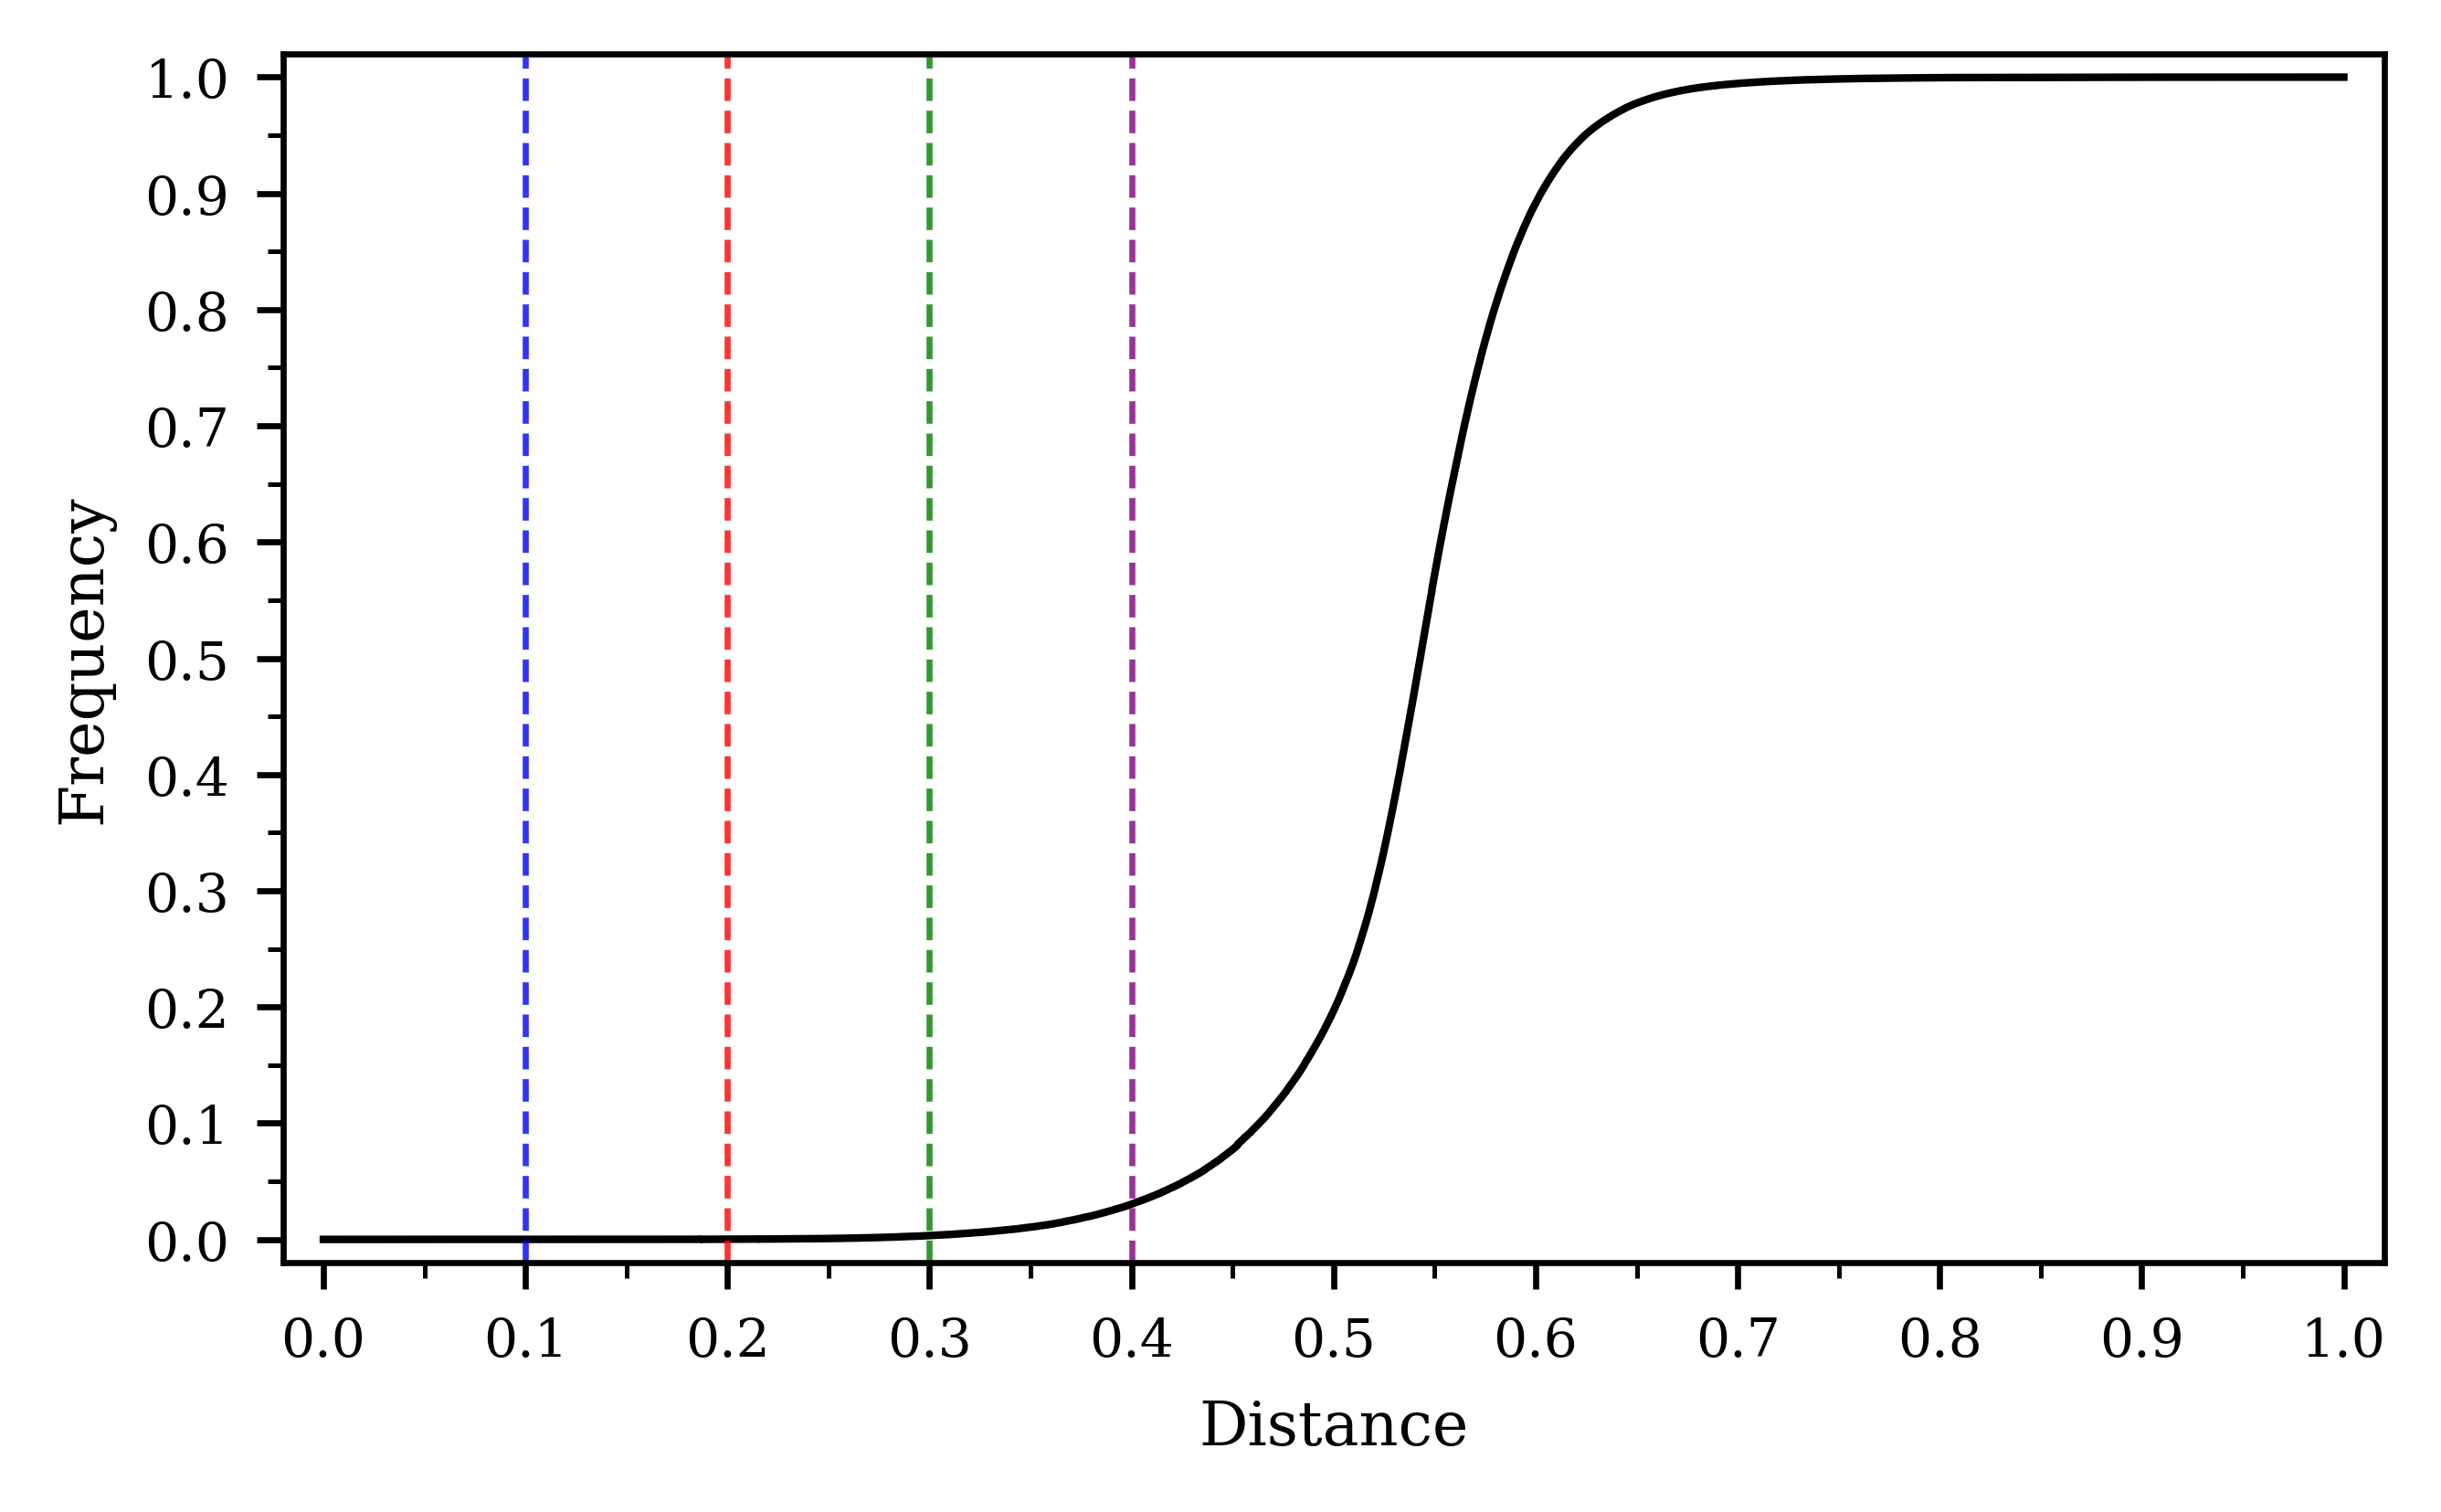

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Sample data (replace with your actual distances) ---
# sorted_distances = np.sort(np.random.rand(10000)**2)
d_min, d_max = np.min(best_distances), np.max(best_distances)
normalized_distances = (best_distances - d_min) / (d_max - d_min)

# --- Compute cumulative probability ---
sorted_norm = np.sort(normalized_distances)
cdf = np.arange(1, len(sorted_norm) + 1) / len(sorted_norm)

# --- Thresholds for annotation ---
thresholds = [0.1, 0.2, 0.3, 0.4]
colors = ["blue", "red", "green", "purple"]
freqs = [np.sum(sorted_norm <= t) for t in thresholds]

# --- Conference style settings ---
plt.rcParams.update({
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "lines.linewidth": 1,
    "figure.dpi": 300,
    "font.family": "serif",
})

fig, ax = plt.subplots(figsize=(4.5, 2.8), dpi=600)

# --- Plot CDF ---
ax.plot(sorted_norm, cdf, color="black", linestyle="-", linewidth=1, label=f"N={len(sorted_norm):,}")

# --- Vertical lines + annotations at the top ---
for t, c, f in zip(thresholds, colors, freqs):
    ax.axvline(x=t, color=c, linestyle="--", linewidth=0.8, alpha=0.8)
    # ax.text(
    #     t + 0.009, 0.90,  # place at the top, slightly above y=1
    #     f"{f:,}\n({t})",
    #     ha="left", va="bottom",
    #     fontsize=6, color=c
    # )

# --- Axes ---
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)  # extend y-limit a bit to fit text above 1.0

ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))

# --- Labels ---
ax.set_xlabel("Distance")
ax.set_ylabel("Frequency")

# --- Export ---
plt.tight_layout()
plt.savefig("distance_cdf.png", dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first vector's distance values
first_vector_distances = similarities[4]  # Shape: (9985596,)

print(f"First vector distance statistics:")
print(f"Shape: {first_vector_distances.shape}")
print(f"Min distance: {np.min(first_vector_distances):.6f}")
print(f"Max distance: {np.max(first_vector_distances):.6f}")
print(f"Mean distance: {np.mean(first_vector_distances):.6f}")
print(f"Std distance: {np.std(first_vector_distances):.6f}")

# Convert distances to similarities
# Common approaches: similarity = 1 / (1 + distance) or similarity = 1 - distance (if normalized)
# Using 1 - distance to convert distances to similarities
first_vector_similarities = 1 - first_vector_distances

# Set negative similarities to zero (in case any exist)
first_vector_similarities = np.maximum(first_vector_similarities, 0)

print(f"\nAfter conversion to similarities:")
print(f"Min similarity: {np.min(first_vector_similarities):.6f}")
print(f"Max similarity: {np.max(first_vector_similarities):.6f}")
print(f"Mean similarity: {np.mean(first_vector_similarities):.6f}")
print(f"Std similarity: {np.std(first_vector_similarities):.6f}")

# Sort similarities in descending order (most similar first)
sorted_similarities = np.sort(first_vector_similarities)[::-1]

# Create frequency plot where x-axis is frequency and y-axis is similarity values
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Frequency vs Similarity plot (as requested)
# Use more bins for better resolution and accuracy
n_bins = 500  # Increased from 100 to 500 for more accurate grid
similarity_bins = np.linspace(np.min(sorted_similarities), np.max(sorted_similarities), n_bins + 1)
bin_centers = (similarity_bins[:-1] + similarity_bins[1:]) / 2
frequencies, _ = np.histogram(sorted_similarities, bins=similarity_bins)

# Plot with better grid and formatting
axes[0].plot(frequencies, bin_centers, 'b-', linewidth=1.5, marker='o', markersize=2)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Similarity Value', fontsize=12)
axes[0].set_title(f'Frequency vs Similarity Values (n_bins={n_bins})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linewidth=0.5)

# Add more detailed grid
axes[0].minorticks_on()
axes[0].grid(True, which='minor', alpha=0.2, linewidth=0.3)

# Format axes for better readability
axes[0].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Add statistics text box
stats_text = f'Total vectors: {len(sorted_similarities):,}\nMax frequency: {np.max(frequencies):,}\nMin similarity: {np.min(sorted_similarities):.6f}\nMax similarity: {np.max(sorted_similarities):.6f}'
axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Traditional histogram for comparison with improved grid
axes[1].hist(sorted_similarities, bins=500, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Similarity Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Distribution of Similarity Values (n_bins={n_bins})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linewidth=0.5)
axes[1].minorticks_on()
axes[1].grid(True, which='minor', alpha=0.2, linewidth=0.3)

# Format axes for better readability
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Add histogram statistics
hist_stats = f'Bin width: {(similarity_bins[1] - similarity_bins[0]):.6f}\nNon-zero bins: {np.count_nonzero(frequencies)}\nPeak frequency: {np.max(frequencies):,}'
axes[1].text(0.02, 0.98, hist_stats, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed frequency statistics
print(f"\n=== FREQUENCY ANALYSIS ===")
print(f"Total vectors: {len(sorted_similarities):,}")
print(f"Number of bins: {n_bins}")
print(f"Bin width: {(similarity_bins[1] - similarity_bins[0]):.8f}")
print(f"Non-zero frequency bins: {np.count_nonzero(frequencies)}")
print(f"Maximum frequency in any bin: {np.max(frequencies):,}")
print(f"Average frequency per bin: {np.mean(frequencies):.2f}")
print(f"Median frequency per bin: {np.median(frequencies):.2f}")

# Show frequency distribution statistics
print(f"\n=== FREQUENCY DISTRIBUTION ===")
print(f"Bins with frequency = 0: {np.sum(frequencies == 0)}")
print(f"Bins with frequency = 1: {np.sum(frequencies == 1)}")
print(f"Bins with frequency 2-10: {np.sum((frequencies >= 2) & (frequencies <= 10))}")
print(f"Bins with frequency 11-100: {np.sum((frequencies >= 11) & (frequencies <= 100))}")
print(f"Bins with frequency 101-1000: {np.sum((frequencies >= 101) & (frequencies <= 1000))}")
print(f"Bins with frequency > 1000: {np.sum(frequencies > 1000)}")

# Show top frequency bins
print(f"\n=== TOP FREQUENCY BINS ===")
top_freq_indices = np.argsort(frequencies)[-10:][::-1]  # Top 10 frequency bins
for i, idx in enumerate(top_freq_indices):
    if frequencies[idx] > 0:
        print(f"Rank {i+1}: Similarity range [{similarity_bins[idx]:.6f}, {similarity_bins[idx+1]:.6f}) -> Frequency: {frequencies[idx]:,}")

# Print statistics about the most similar vectors
print(f"\n=== TOP SIMILAR VECTORS ===")
print(f"Top 10 most similar vectors:")
for i in range(10):
    print(f"Rank {i+1}: {sorted_similarities[i]:.6f}")

print(f"\nTop 100 most similar vectors range: {sorted_similarities[99]:.6f} to {sorted_similarities[0]:.6f}")
print(f"Top 1000 most similar vectors range: {sorted_similarities[999]:.6f} to {sorted_similarities[0]:.6f}")

# Additional analysis: show how many vectors have high similarity
high_similarity_threshold = 0.8
high_sim_count = np.sum(sorted_similarities >= high_similarity_threshold)
print(f"\nVectors with similarity >= {high_similarity_threshold}: {high_sim_count} ({high_sim_count/len(sorted_similarities)*100:.2f}%)")


In [ ]:
# Open and read entire file
with open('/data2/ali/laion-dataset/001158699.txt', 'r') as file:
    content = file.read()
    print(content)

In [ ]:
import json

# Open and read JSON file
with open('/data2/ali/laion-dataset/001158699.json', 'r') as file:
    data = json.load(file)
    print(data)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Read the CSV data
df = pd.read_csv('/home/ali/hnswlib/results/fullopenaidecompose_hnsw_efficientpost_dynamic.csv')

# Remove any empty rows
df = df.dropna()

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nUnique k values:", sorted(df['k'].unique()))
print("Threshold multiplier range:", df['threshold_multiplier'].min(), "to", df['threshold_multiplier'].max())

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('HNSW Performance Analysis: Threshold Multiplier vs Recall & QPS', fontsize=16, fontweight='bold')

# Plot 1: Recall vs Threshold Multiplier for different k values
ax1 = axes[0, 0]
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k]
    ax1.plot(k_data['threshold_multiplier'], k_data['Recall'], 
             marker='o', linewidth=2, markersize=6, label=f'k={k}')

ax1.set_xlabel('Threshold Multiplier')
ax1.set_ylabel('Recall')
ax1.set_title('Recall vs Threshold Multiplier')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1.0, 1.21)

# Plot 2: QPS vs Threshold Multiplier for different k values
ax2 = axes[0, 1]
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k]
    ax2.plot(k_data['threshold_multiplier'], k_data['QPS'], 
             marker='s', linewidth=2, markersize=6, label=f'k={k}')

ax2.set_xlabel('Threshold Multiplier')
ax2.set_ylabel('QPS (Queries Per Second)')
ax2.set_title('QPS vs Threshold Multiplier')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1.0, 1.21)

# Plot 3: Recall vs QPS (scatter plot colored by k)
ax3 = axes[1, 0]
scatter = ax3.scatter(df['QPS'], df['Recall'], c=df['k'], 
                     cmap='viridis', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('QPS (Queries Per Second)')
ax3.set_ylabel('Recall')
ax3.set_title('Recall vs QPS (colored by k)')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('k (Number of Neighbors)')
ax3.grid(True, alpha=0.3)

# Plot 4: Heatmap of Recall values
ax4 = axes[1, 1]
# Create pivot table for heatmap
pivot_recall = df.pivot(index='k', columns='threshold_multiplier', values='Recall')
im = ax4.imshow(pivot_recall.values, cmap='RdYlBu_r', aspect='auto')
ax4.set_xticks(range(len(pivot_recall.columns)))
ax4.set_xticklabels([f'{x:.2f}' for x in pivot_recall.columns], rotation=45)
ax4.set_yticks(range(len(pivot_recall.index)))
ax4.set_yticklabels(pivot_recall.index)
ax4.set_xlabel('Threshold Multiplier')
ax4.set_ylabel('k (Number of Neighbors)')
ax4.set_title('Recall Heatmap')

# Add colorbar for heatmap
cbar2 = plt.colorbar(im, ax=ax4)
cbar2.set_label('Recall')

# Add text annotations to heatmap
for i in range(len(pivot_recall.index)):
    for j in range(len(pivot_recall.columns)):
        text = ax4.text(j, i, f'{pivot_recall.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.savefig('/home/ali/hnswlib/hnsw_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create additional detailed analysis plots
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Detailed Performance Analysis', fontsize=16, fontweight='bold')

# Plot 5: Recall improvement with threshold multiplier
ax5 = axes2[0]
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k].sort_values('threshold_multiplier')
    # Calculate improvement from baseline (threshold_multiplier = 1.01)
    baseline_recall = k_data[k_data['threshold_multiplier'] == 1.01]['Recall'].iloc[0]
    improvement = ((k_data['Recall'] - baseline_recall) / baseline_recall) * 100
    ax5.plot(k_data['threshold_multiplier'], improvement, 
             marker='o', linewidth=2, markersize=6, label=f'k={k}')

ax5.set_xlabel('Threshold Multiplier')
ax5.set_ylabel('Recall Improvement (%)')
ax5.set_title('Recall Improvement vs Threshold Multiplier')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 6: QPS degradation with threshold multiplier
ax6 = axes2[1]
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k].sort_values('threshold_multiplier')
    # Calculate degradation from baseline (threshold_multiplier = 1.01)
    baseline_qps = k_data[k_data['threshold_multiplier'] == 1.01]['QPS'].iloc[0]
    degradation = ((k_data['QPS'] - baseline_qps) / baseline_qps) * 100
    ax6.plot(k_data['threshold_multiplier'], degradation, 
             marker='s', linewidth=2, markersize=6, label=f'k={k}')

ax6.set_xlabel('Threshold Multiplier')
ax6.set_ylabel('QPS Degradation (%)')
ax6.set_title('QPS Degradation vs Threshold Multiplier')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 7: Efficiency metric (Recall/QPS ratio)
ax7 = axes2[2]
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k]
    efficiency = k_data['Recall'] / k_data['QPS']
    ax7.plot(k_data['threshold_multiplier'], efficiency, 
             marker='^', linewidth=2, markersize=6, label=f'k={k}')

ax7.set_xlabel('Threshold Multiplier')
ax7.set_ylabel('Efficiency (Recall/QPS)')
ax7.set_title('Efficiency vs Threshold Multiplier')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/ali/hnswlib/hnsw_detailed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nRecall Statistics:")
print(f"  Min: {df['Recall'].min():.3f}")
print(f"  Max: {df['Recall'].max():.3f}")
print(f"  Mean: {df['Recall'].mean():.3f}")
print(f"  Std: {df['Recall'].std():.3f}")

print(f"\nQPS Statistics:")
print(f"  Min: {df['QPS'].min():.1f}")
print(f"  Max: {df['QPS'].max():.1f}")
print(f"  Mean: {df['QPS'].mean():.1f}")
print(f"  Std: {df['QPS'].std():.1f}")

print(f"\nBest Recall by k:")
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k]
    best_recall_idx = k_data['Recall'].idxmax()
    best_recall = k_data.loc[best_recall_idx]
    print(f"  k={k}: {best_recall['Recall']:.3f} (threshold={best_recall['threshold_multiplier']:.2f}, QPS={best_recall['QPS']:.1f})")

print(f"\nBest QPS by k:")
for k in sorted(df['k'].unique()):
    k_data = df[df['k'] == k]
    best_qps_idx = k_data['QPS'].idxmax()
    best_qps = k_data.loc[best_qps_idx]
    print(f"  k={k}: {best_qps['QPS']:.1f} (threshold={best_qps['threshold_multiplier']:.2f}, Recall={best_qps['Recall']:.3f})")

print(f"\nFiles saved:")
print(f"  - /home/ali/hnswlib/hnsw_performance_analysis.png")
print(f"  - /home/ali/hnswlib/hnsw_detailed_analysis.png")


In [ ]:
sorted_distances, sorted_ids


In [ ]:
int(sorted_ids[100])

In [ ]:
def get_data_points_by_cluster(distances, cluster_ids, target_cluster_id, query_idx=None):
    """
    Retrieve all data points that belong to a specific cluster ID.
    
    Parameters:
    distances: numpy array of distances (shape: (N, M) or (M,))
    cluster_ids: numpy array of cluster IDs (shape: (N, M) or (M,))
    target_cluster_id: int, the cluster ID to search for
    query_idx: int or None, if provided, search only in that specific query row
    
    Returns:
    dict: Contains filtered data with distances and cluster IDs for the target cluster
    """
    
    if query_idx is not None:
        # Search in specific query
        if distances.ndim == 1:
            # Single query case
            mask = cluster_ids == target_cluster_id
            filtered_distances = distances[mask]
            filtered_cluster_ids = cluster_ids[mask]
            filtered_indices = np.where(mask)[0]
        else:
            # Multiple queries case - search in specific row
            mask = cluster_ids[query_idx] == target_cluster_id
            filtered_distances = distances[query_idx][mask]
            filtered_cluster_ids = cluster_ids[query_idx][mask]
            filtered_indices = np.where(mask)[0]
    else:
        # Search across all queries
        if distances.ndim == 1:
            # Single query case
            mask = cluster_ids == target_cluster_id
            filtered_distances = distances[mask]
            filtered_cluster_ids = cluster_ids[mask]
            filtered_indices = np.where(mask)[0]
        else:
            # Multiple queries case - search across all rows
            all_distances = []
            all_cluster_ids = []
            all_indices = []
            all_query_indices = []
            
            for i in range(distances.shape[0]):
                mask = cluster_ids[i] == target_cluster_id
                if np.any(mask):
                    all_distances.extend(distances[i][mask])
                    all_cluster_ids.extend(cluster_ids[i][mask])
                    all_indices.extend(np.where(mask)[0])
                    all_query_indices.extend([i] * np.sum(mask))
            
            filtered_distances = np.array(all_distances)
            filtered_cluster_ids = np.array(all_cluster_ids)
            filtered_indices = np.array(all_indices)
            filtered_query_indices = np.array(all_query_indices)
    
    result = {
        'distances': filtered_distances,
        'cluster_ids': filtered_cluster_ids,
        'indices': filtered_indices,
        'count': len(filtered_distances)
    }
    
    # Add query indices if searching across multiple queries
    if query_idx is None and distances.ndim > 1:
        result['query_indices'] = filtered_query_indices
    
    return result


# Get data points for this cluster in query 0
cluster_data = get_data_points_by_cluster(distances, cluster_ids, target_cluster, query_idx=0)
